# Prerequisites

In [ ]:
# mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.0 MB/s eta 0:00:00


# Step-1 Importing Libraries

In [ ]:
# importing libraries
import  numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import keras
import torch
from keras import regularizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout, ActivityRegularization, GlobalAveragePooling2D
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
import keras_tuner as kt
from keras.models import save_model, load_model
import itertools

In [ ]:
# use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


# Step-2 Loading the EMNIST dataset using Pandas

In [ ]:
# fix random seed for reproducibility
np.random.seed(42)

# download the dataset
# providing the path to load the dataset from the google drive
%cd /content/drive/My Drive/Colab Notebooks/COMP534/Assignment2
train_data=pd.read_csv("emnist-balanced-train.csv",header=None)
test_data=pd.read_csv("emnist-balanced-test.csv",header=None)

/content/drive/My Drive/Colab Notebooks/COMP534/Assignment2


# Step-3 Splitting the Dataset into training and testing dataset

In [ ]:
# spliting the train and test data into features and labels
X_train_full = train_data.iloc[:,1:].values.astype(np.uint8)
y_train_full = train_data.iloc[:,0].values.astype(np.uint8)

X_test = test_data.iloc[:,1:].values.astype(np.uint8)
y_test = test_data.iloc[:,0].values.astype(np.uint8)

In [ ]:
# create a validation data set from the full trainig data
X_valid, X_train = X_train_full[:10000], X_train_full[10000:]
y_valid, y_train = y_train_full[:10000], y_train_full[10000:]

In [ ]:
# Transform labels-One Hot Encoding
number_of_classes = 47

train_labels = tf.keras.utils.to_categorical(y_train, number_of_classes)
train_labels_valid = tf.keras.utils.to_categorical(y_valid, number_of_classes)
test_labels = tf.keras.utils.to_categorical(y_test, number_of_classes)

#print first ten (integer-valued) training labels
print("Integer-valued labels:")
print(y_train[:3])
# print first ten (one-hot) training labels
print("One-hot labels:")
print(train_labels[:3])

Integer-valued labels:
[12 39  4]
One-hot labels:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


# Step-4 Understanding the dataset and visualise the dataset

## 4.a)  Printing-out the number of training/testing samples in the dataset

In [ ]:
# a) Print the number of training/testing samples
print("Number of training samples:", X_train_full.shape[0])
print("Number of testing samples:", X_test.shape[0])

Number of training samples: 112800
Number of testing samples: 18800


## 4.b) Plotting some figures to visualize some samples

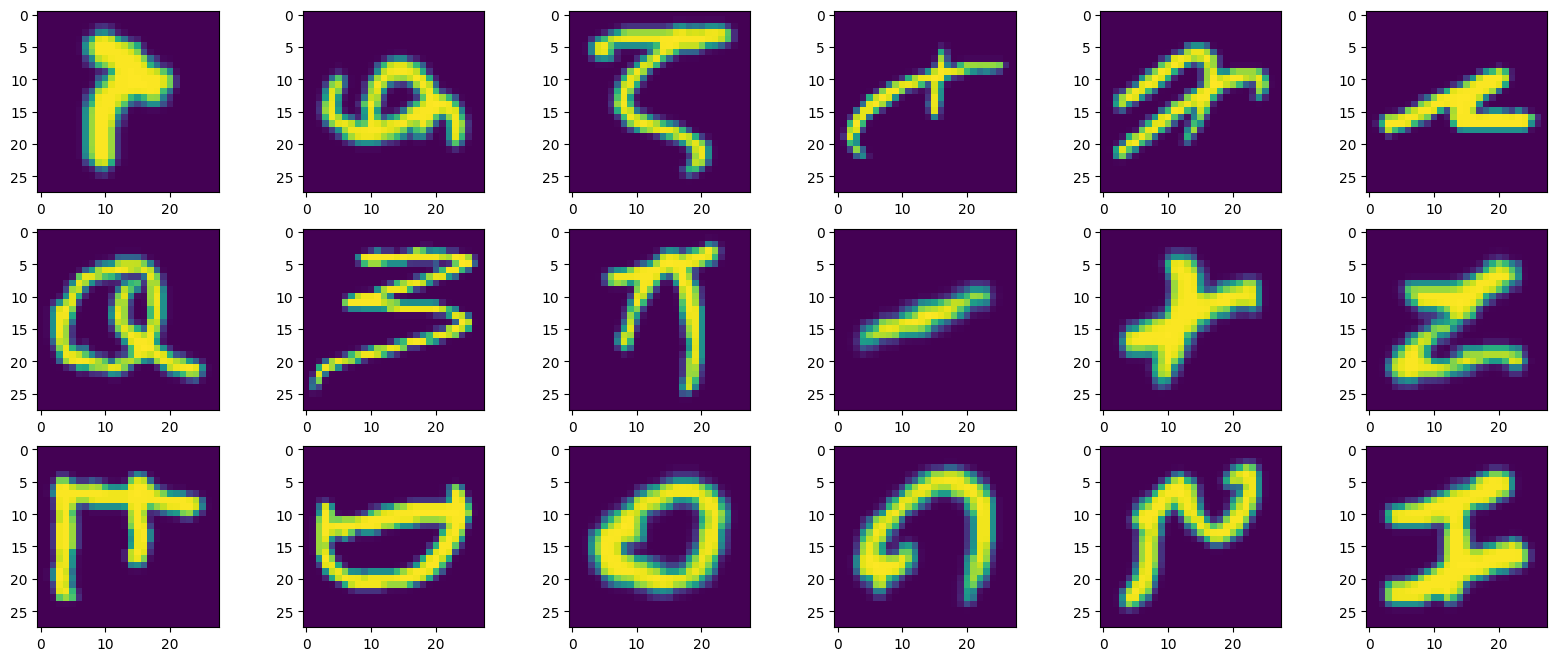

In [ ]:
fig,axes = plt.subplots(3,6,figsize=(20,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(X_train_full[i].reshape([28,28]))

# Step-5 Building the model- MLP & CNN

## 5.1 Neural Network Model- MLP (Multilayer Perceptron)

### 5.1.1 Preprocessing for MLP

In [ ]:
# Normalise and reshape data
train_images = X_train / 255.0
train_images_valid=X_valid/255.0
test_images = X_test / 255.0

train_images_number = train_images.shape[0]
train_images = train_images.reshape(train_images_number, 28, 28)

train_images_valid_number = train_images_valid.shape[0]
train_images_valid = train_images_valid.reshape(train_images_valid_number, 28, 28)

test_images_number = test_images.shape[0]
test_images = test_images.reshape(test_images_number, 28, 28)

### 5.1.2 Baseline model configuration - MLP


#### 5.1.2.1 Define the model

In [ ]:
#define the model
# Creating a Sequential model instance
model = Sequential()

# Flattening layer to transform the 28x28 input images into a 1D array
model.add(Flatten(input_shape=[28,28],name="inputLayer"))

# First dense layer with 128 units, ReLU activation function, L2 regularization, and GlorotNormal kernel initializer
model.add(Dense(units=128, activation="relu", kernel_regularizer=regularizers.L2(1e-4), kernel_initializer=tf.keras.initializers.GlorotNormal()))

# Dropout layer with a dropout rate of 20% to prevent overfitting
model.add(Dropout(0.2))

# Second dense layer with 64 units, ReLU activation function, L1 regularization, and GlorotNormal kernel initializer
model.add(Dense(units=64, activation="relu", kernel_regularizer=regularizers.L1(1e-5), kernel_initializer=tf.keras.initializers.GlorotNormal()))

# Dropout layer with a dropout rate of 10%
model.add(Dropout(0.1))

# Third dense layer with 32 units, ReLU activation function, L1L2 regularization, and GlorotNormal kernel initializer
model.add(Dense(units=32, activation="relu", kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), kernel_initializer=tf.keras.initializers.GlorotNormal()))

# Dropout layer with a dropout rate of 20%
model.add(Dropout(0.2))

# Fourth dense layer with 16 units, ReLU activation function, L1L2 regularization, and GlorotNormal kernel initializer
model.add(Dense(units=16, activation="relu", kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), kernel_initializer=tf.keras.initializers.GlorotNormal()))

# Dropout layer with a dropout rate of 20%
model.add(Dropout(0.2))

# Output layer with 47 units (representing the number of classes) and softmax activation function
model.add(Dense(units=47, activation="softmax"))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (Flatten)        (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0

#### 5.1.2.2 Compiling the Model

In [ ]:
LOSS_FUNCTION="sparse_categorical_crossentropy" # use => tf.losses.spare_categorical_crossentropy
OPTIMIZER="SGD" # or use with custom learning rate => tf.keras.optimizers.SGD(0.02)
METRICS=["accuracy"]

model.compile(loss=LOSS_FUNCTION,optimizer=OPTIMIZER,metrics=METRICS)

#### 5.1.2.3 Traning with MLP (Baseline model)

In [ ]:
# Number of epochs
EPOCHS=20
# Defining the validation data
VALIDATION_SET=(train_images_valid,y_valid)

# Checking for runtime
start_time = time.time()

#batch size-> we are going to send batch of 32 through the NN
history=model.fit(train_images,y_train,epochs=EPOCHS,validation_data=VALIDATION_SET,batch_size=32)

end_time=time.time()
training_time = end_time - start_time
print("Training Time: {:.2f} seconds".format(training_time))

Epoch 1/20
3213/3213 [==============================] - 15s 4ms/step - loss: 3.5960 - accuracy: 0.0857 - val_loss: 2.7524 - val_accuracy: 0.2882
Epoch 2/20
3213/3213 [==============================] - 14s 4ms/step - loss: 2.6883 - accuracy: 0.2407 - val_loss: 1.9027 - val_accuracy: 0.4900
Epoch 3/20
3213/3213 [==============================] - 14s 4ms/step - loss: 2.2531 - accuracy: 0.3382 - val_loss: 1.5487 - val_accuracy: 0.5877
Epoch 4/20
3213/3213 [==============================] - 14s 4ms/step - loss: 2.0118 - accuracy: 0.3998 - val_loss: 1.3449 - val_accuracy: 0.6343
Epoch 5/20
3213/3213 [==============================] - 14s 4ms/step - loss: 1.8555 - accuracy: 0.4418 - val_loss: 1.2231 - val_accuracy: 0.6731
Epoch 6/20
3213/3213 [==============================] - 14s 4ms/step - loss: 1.7491 - accuracy: 0.4728 - val_loss: 1.1396 - val_accuracy: 0.6877
Epoch 7/20
3213/3213 [==============================] - 15s 5ms/step - loss: 1.6622 - accuracy: 0.4983 - val_loss: 1.0753 - val_ac

In [ ]:
# Save the model
model.save('baseline_mlp_model.h5',  overwrite=True)

#### 5.1.2.4 Visualising the (val_)loss and (val_)accuracy

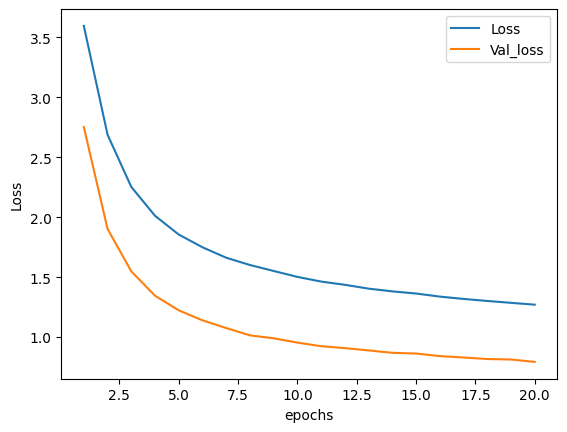

In [ ]:
q = len(history.history['loss'])

plt.figsize=(10,10)
sns.lineplot(x = range(1,1+q),y = history.history['loss'], label='Loss')
sns.lineplot(x = range(1,1+q),y = history.history['val_loss'], label='Val_loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.show()

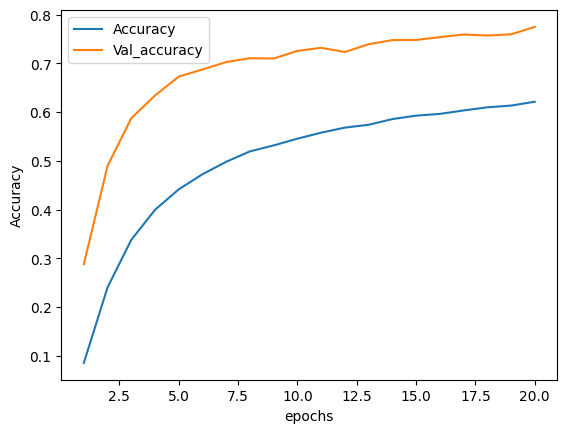

In [ ]:
q = len(history.history['accuracy'])

plt.figsize=(10,10)
sns.lineplot(x = range(1,1+q),y = history.history['accuracy'], label='Accuracy')
sns.lineplot(x = range(1,1+q),y = history.history['val_accuracy'], label='Val_accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.show()

### 5.1.a Hyperparameter Tuning for MLP

#### 5.1.a.1 Defining the Model

In [ ]:
## MODEL BUILDING

def build_model_mlp(hp):

  # Initialize a Sequential model
  model = Sequential()
  # Adding the input laye
  model.add(Flatten(input_shape=[28,28],name="inputLayer"))

    # Loop over the number of layers specified by the hyperparameter
  for i in range(hp.Int("num_layers", min_value=1, max_value=10)):

    # Define hyperparameters for the dense layers
    neurons=hp.Int("neurons_" + str(i), min_value=8, max_value=128)
    activation=hp.Choice("activation_" + str(i), values=["relu", "tanh", "leaky_relu", "elu"])
    dropout=hp.Choice("dropout_" + str(i), values=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    # Add subsequent layers with weight initializer (HeNormal)
    model.add(Dense(units=neurons, activation=activation,kernel_initializer=tf.keras.initializers.HeNormal() ))

    # Tune whether to use L1 & L2 regularization
    if hp.Boolean("regularization"):
      model.add(ActivityRegularization(
          l1=hp.Int("L1_" + str(i),values=np.arange(0.0, 0.011, 0.001)),
          l2=hp.Int("L2_" + str(i),values=np.arange(0.0, 0.011, 0.001))
      ))

    # Tune whether to use batch normalization
    if hp.Boolean("batch normalization"):
      model.add(BatchNormalization())

    # Tune whether to use dropout.
    if hp.Boolean("dropout"):
      model.add(Dropout(rate=dropout))

  # Add output layer with 47 neuron as equal the number of labels (classes) and softmax activation for multi-classification
  model.add(Dense(47, activation="softmax"))

  # Compile the model with hyperparameters
  model.compile(
        optimizer=hp.Choice("optimizer", values=["adam", "sgd", "rmsprop", "adadelta"]),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

  return model

In [ ]:
# Initialize a RandomSearch tuner for hyperparameter optimization
tuner=kt.RandomSearch(build_model_mlp,
                      objective="val_accuracy",
                      max_trials=3,
                      overwrite=True,
                      directory="mydir",
                      project_name="emnist_mlp_model")

In [ ]:
# Search for the best hyperparameters using the training data
tuner.search(train_images,y_train,epochs=5,validation_data=(train_images_valid,y_valid))

Trial 3 Complete [00h 00m 00s]

Best val_accuracy So Far: 0.7372000217437744
Total elapsed time: 00h 02m 48s


In [ ]:
# Best hyperparameter after tuning the model
tuner.get_best_hyperparameters()[0].values

{'num_layers': 3,
 'neurons_0': 93,
 'activation_0': 'leaky_relu',
 'dropout_0': 0.7,
 'regularization': False,
 'batch normalization': False,
 'dropout': False,
 'optimizer': 'adam',
 'neurons_1': 8,
 'activation_1': 'relu',
 'dropout_1': 0.1,
 'neurons_2': 8,
 'activation_2': 'relu',
 'dropout_2': 0.1}

In [ ]:
# Getting the best model
model=tuner.get_best_models(num_models=1)[0]

In [ ]:
# Summary of the best model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (Flatten)        (None, 784)               0         
                                                                 
 dense (Dense)               (None, 93)                73005     
                                                                 
 dense_1 (Dense)             (None, 8)                 752       
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 47)                423       
                                                                 
Total params: 74252 (290.05 KB)
Trainable params: 74252 (290.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Save the model
model.save('best_mlp_model.h5', overwrite=True)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### 5.1.a.2 Training with Adaptive Learning Rate

In [ ]:
## 1.1 Adaptive Learning Rate- learning rate schedulers
# This function keeps the initial learning rate for the first five epochs and decreases it exponentially after that.
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_scheduler=LearningRateScheduler(scheduler, verbose=0)

## 1.2 Adaptive Learning Rate- Reduce LR on Plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

In [ ]:
# Model for Adaptive Learning Rate- learning rate schedulers
model_lr_sch=tuner.get_best_models(num_models=1)[0]

# Model for Adaptive Learning Rate- Reduce LR on Plateau
model_reduce_lr=tuner.get_best_models(num_models=1)[0]

##### 5.1.a.2.1 Training with Learning rate schedulers

In [ ]:
# Using learning rate schedulers as an adaptive learning rate

start_time=time.time()

hist_lr_sch_mlp=model_lr_sch.fit(train_images,y_train,epochs=20,initial_epoch=5,validation_data=(train_images_valid,y_valid),callbacks=[lr_scheduler])

end_time=time.time()

training_time=end_time-start_time

print("Training Time: {:.2f} seconds".format(training_time))

Epoch 6/20
3213/3213 [==============================] - 11s 3ms/step - loss: 0.7968 - accuracy: 0.7493 - val_loss: 0.8117 - val_accuracy: 0.7484 - lr: 9.0484e-04
Epoch 7/20
3213/3213 [==============================] - 9s 3ms/step - loss: 0.7508 - accuracy: 0.7634 - val_loss: 0.7753 - val_accuracy: 0.7592 - lr: 8.1873e-04
Epoch 8/20
3213/3213 [==============================] - 11s 3ms/step - loss: 0.7156 - accuracy: 0.7716 - val_loss: 0.7589 - val_accuracy: 0.7627 - lr: 7.4082e-04
Epoch 9/20
3213/3213 [==============================] - 10s 3ms/step - loss: 0.6900 - accuracy: 0.7802 - val_loss: 0.7839 - val_accuracy: 0.7507 - lr: 6.7032e-04
Epoch 10/20
3213/3213 [==============================] - 8s 3ms/step - loss: 0.6671 - accuracy: 0.7864 - val_loss: 0.7201 - val_accuracy: 0.7750 - lr: 6.0653e-04
Epoch 11/20
3213/3213 [==============================] - 10s 3ms/step - loss: 0.6482 - accuracy: 0.7911 - val_loss: 0.7208 - val_accuracy: 0.7742 - lr: 5.4881e-04
Epoch 12/20
3213/3213 [=====

In [ ]:
# Saving the model
model_lr_sch.save("best_mlp_w_lr_sch.h5", overwrite=True)

##### 5.1.a.2.2 Visualising with plots

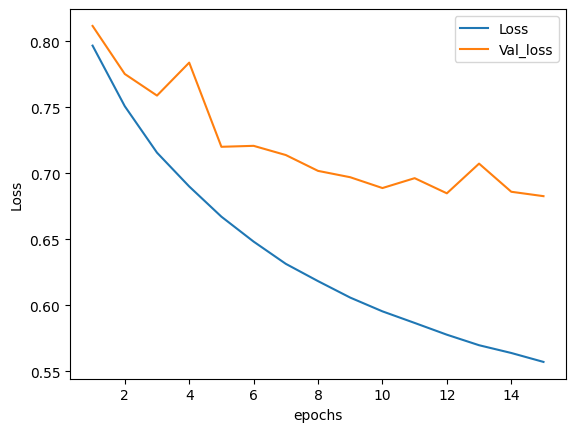

In [ ]:
q = len(hist_lr_sch_mlp.history['loss'])

plt.figsize=(10,10)
sns.lineplot(x = range(1,1+q),y = hist_lr_sch_mlp.history['loss'], label='Loss')
sns.lineplot(x = range(1,1+q),y = hist_lr_sch_mlp.history['val_loss'], label='Val_loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.show()

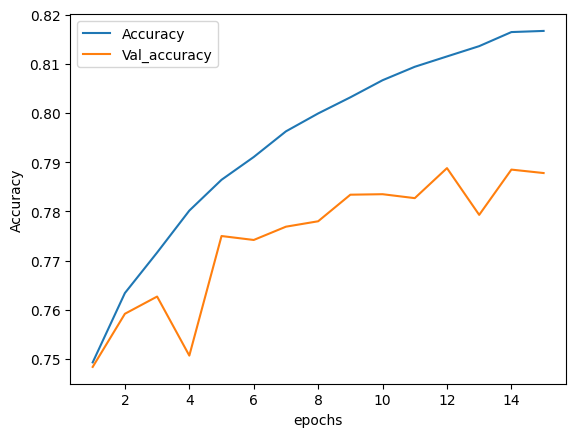

In [ ]:
q = len(hist_lr_sch_mlp.history['accuracy'])

plt.figsize=(10,10)
sns.lineplot(x = range(1,1+q),y = hist_lr_sch_mlp.history['accuracy'], label='Accuracy')
sns.lineplot(x = range(1,1+q),y = hist_lr_sch_mlp.history['val_accuracy'], label='Val_accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.show()

##### 5.1.a.2.3 Training with Reduce Learning Rate on Plateau

In [ ]:
# Using Reduce LR on Plateau as an adaptive learning rate

start_time=time.time()

hist_reduce_lr_mlp=model_reduce_lr.fit(train_images,y_train,epochs=20,initial_epoch=5,validation_data=(train_images_valid,y_valid),callbacks=[reduce_lr])

end_time=time.time()

training_time=end_time-start_time

print("Training Time: {:.2f} seconds".format(training_time))

Epoch 6/20
3213/3213 [==============================] - 11s 3ms/step - loss: 0.8064 - accuracy: 0.7463 - val_loss: 0.8156 - val_accuracy: 0.7480 - lr: 0.0010
Epoch 7/20
3213/3213 [==============================] - 10s 3ms/step - loss: 0.7661 - accuracy: 0.7587 - val_loss: 0.7859 - val_accuracy: 0.7501 - lr: 0.0010
Epoch 8/20
3213/3213 [==============================] - 10s 3ms/step - loss: 0.7349 - accuracy: 0.7661 - val_loss: 0.7606 - val_accuracy: 0.7598 - lr: 0.0010
Epoch 9/20
3213/3213 [==============================] - 10s 3ms/step - loss: 0.7137 - accuracy: 0.7712 - val_loss: 0.7569 - val_accuracy: 0.7641 - lr: 0.0010
Epoch 10/20
3213/3213 [==============================] - 8s 3ms/step - loss: 0.6910 - accuracy: 0.7777 - val_loss: 0.7503 - val_accuracy: 0.7655 - lr: 0.0010
Epoch 11/20
3213/3213 [==============================] - 10s 3ms/step - loss: 0.6751 - accuracy: 0.7811 - val_loss: 0.7382 - val_accuracy: 0.7706 - lr: 0.0010
Epoch 12/20
3213/3213 [============================

In [ ]:
# Saving the model
model_reduce_lr.save("best_mlp_w_reduce_lr.h5", overwrite=True)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##### 5.1.a.2.4 Visualising with plots

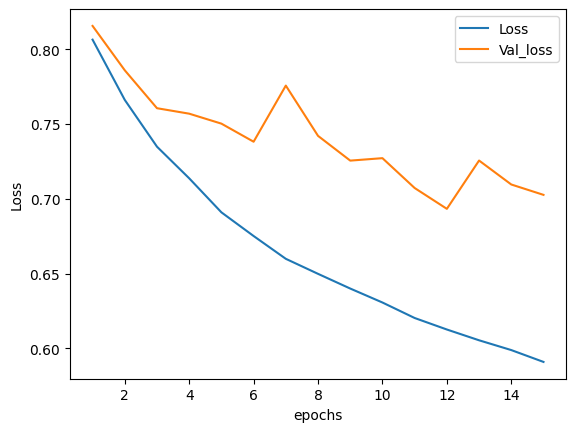

In [ ]:
q = len(hist_reduce_lr_mlp.history['loss'])

plt.figsize=(10,10)
sns.lineplot(x = range(1,1+q),y = hist_reduce_lr_mlp.history['loss'], label='Loss')
sns.lineplot(x = range(1,1+q),y = hist_reduce_lr_mlp.history['val_loss'], label='Val_loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.show()

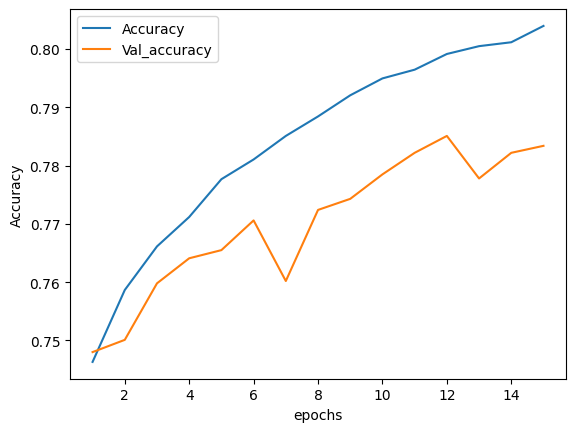

In [ ]:
q = len(hist_reduce_lr_mlp.history['accuracy'])

plt.figsize=(10,10)
sns.lineplot(x = range(1,1+q),y = hist_reduce_lr_mlp.history['accuracy'], label='Accuracy')
sns.lineplot(x = range(1,1+q),y = hist_reduce_lr_mlp.history['val_accuracy'], label='Val_accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.show()

## 5.2 Neural Network Model- CNN (Convolution Neural Network)

### 5.2.1 Preprocessing for CNN

In [ ]:
# Normalise and reshape data
train_images = X_train / 255.0
train_images_valid=X_valid/255.0
test_images = X_test / 255.0

train_images_number = train_images.shape[0]
train_images = train_images.reshape(train_images_number, 28, 28, 1)

train_images_valid_number = train_images_valid.shape[0]
train_images_valid = train_images_valid.reshape(train_images_valid_number, 28, 28, 1)

test_images_number = test_images.shape[0]
test_images = test_images.reshape(test_images_number, 28, 28, 1)

### 5.2.2 Baseline model configuration- CNN

#### 5.2.2.1 Defining the Model

In [ ]:
# build the model object
model=Sequential()

# CONV_1: add CONV layer with ReLU activation and depth =32 kernels
model.add(Conv2D(32,kernel_size=(3,3),padding="same",activation="relu",input_shape=(28,28,1)))
# POOL_1: downsample the image to choose the best features
model.add(MaxPooling2D(pool_size=(2,2)))

# CONV_2: here we increase the depth of 64
model.add(Conv2D(64,(3,3),padding="same",activation="relu"))
# POOL_2: more downsampling
model.add(MaxPooling2D(pool_size=(2,2)))

# flatten since too many dimensions, we only want a classification output
model.add(Flatten())

# FC_1: fully connected to ge all relevant data
model.add(Dense(128,activation="relu"))

# FC_2: fully connected to ge all relevant data
model.add(Dense(64,activation="relu"))

# FC_3: output a softmax to squash the matrix into output probabilities for the
model.add(Dense(47,activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense_5 (Dense)             (None, 128)              

#### 5.2.2.2 Compiling the Model

In [ ]:
# Complie the model
model.compile(loss="categorical_crossentropy",optimizer="rmsprop",metrics=["accuracy"])

#### 5.2.2.3 Training with CNN (Baseline Model)

In [ ]:
#train the model
checkpointer=ModelCheckpoint(filepath="model.best.weight.hdf5",overwrite=True,verbose=1,save_best_only=True)

start_time=time.time()

hist=model.fit(train_images,train_labels,batch_size=64,epochs=10,
               validation_data=(test_images,test_labels),callbacks=[checkpointer],
               verbose=2,shuffle=True)

end_time=time.time()

training_time=end_time-start_time

print("Training Time: {:.2f} seconds".format(training_time))

Epoch 1/10

Epoch 1: val_loss improved from inf to 0.49902, saving model to model.best.weight.hdf5
1607/1607 - 123s - loss: 0.7862 - accuracy: 0.7563 - val_loss: 0.4990 - val_accuracy: 0.8288 - 123s/epoch - 77ms/step
Epoch 2/10

Epoch 2: val_loss improved from 0.49902 to 0.43151, saving model to model.best.weight.hdf5
1607/1607 - 116s - loss: 0.4117 - accuracy: 0.8583 - val_loss: 0.4315 - val_accuracy: 0.8559 - 116s/epoch - 72ms/step
Epoch 3/10

Epoch 3: val_loss improved from 0.43151 to 0.39353, saving model to model.best.weight.hdf5
1607/1607 - 115s - loss: 0.3487 - accuracy: 0.8760 - val_loss: 0.3935 - val_accuracy: 0.8677 - 115s/epoch - 72ms/step
Epoch 4/10

Epoch 4: val_loss improved from 0.39353 to 0.37468, saving model to model.best.weight.hdf5
1607/1607 - 120s - loss: 0.3110 - accuracy: 0.8875 - val_loss: 0.3747 - val_accuracy: 0.8684 - 120s/epoch - 75ms/step
Epoch 5/10

Epoch 5: val_loss did not improve from 0.37468
1607/1607 - 118s - loss: 0.2837 - accuracy: 0.8964 - val_loss

#### 5.2.2.4 Visualisation

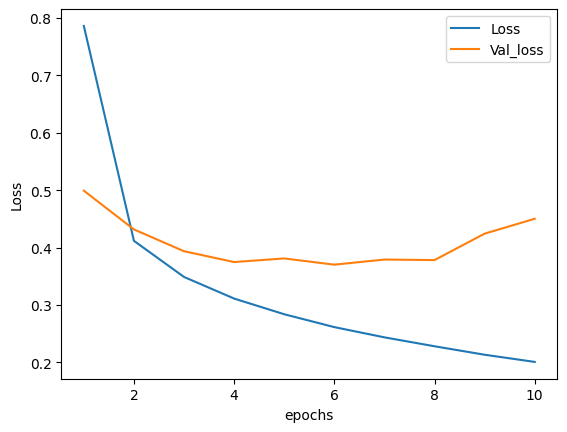

In [ ]:
q = len(hist.history['loss'])

plt.figsize=(10,10)
sns.lineplot(x = range(1,1+q),y = hist.history['loss'], label='Loss')
sns.lineplot(x = range(1,1+q),y = hist.history['val_loss'], label='Val_loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.show()

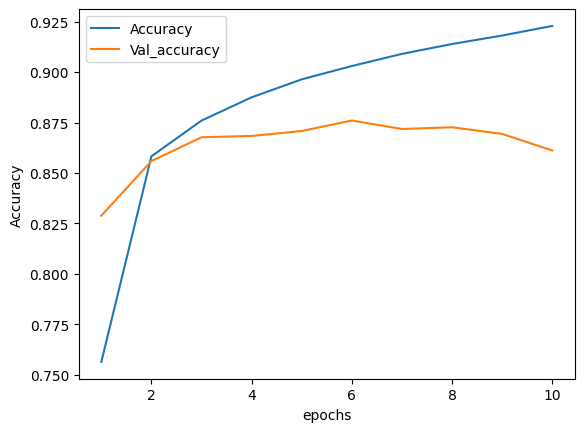

In [ ]:
q = len(hist.history['accuracy'])

plt.figsize=(10,10)
sns.lineplot(x = range(1,1+q),y = hist.history['accuracy'], label='Accuracy')
sns.lineplot(x = range(1,1+q),y = hist.history['val_accuracy'], label='Val_accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# Save the model
model.save('baseline_cnn_model.h5', overwrite=True)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### 5.2.a Hyperparapeter tuning for CNN

##### 5.2.a.1 Defining the model

In [ ]:
# MODEL BUILDING
def build_model_cnn(hp):

  # Initialize a Sequential model
  model=Sequential()

  # Adding the convolutional input layer
  model.add(Conv2D(
      filters=hp.Int("conv_input_filter", min_value=32,max_value=128,step=8),
      kernel_size=hp.Choice("conv_input_kernel",values=[3,5]),
      padding=hp.Choice("conv_input_padding",values=["same","valid"]),
      activation=hp.Choice("conv__input_activation",values=["relu","tanh", "elu"]),
      input_shape=(28,28,1)
      ))

  # Define hyperparameters for the convolutional layers
  filters_conv=hp.Int("conv_filter" , min_value=64,max_value=128,step=8)
  kernel_conv=hp.Choice("conv_kernel",values=[3,5])
  pool_size=(2,2)
  activation_conv=hp.Choice("conv_activation",values=["relu","tanh", "elu", "leaky_relu"])
  dropout_coeff_conv = hp.Float("conv_dropout", min_value=0.05, max_value=0.2)

  # Add the convolutional layer
  model.add(Conv2D(filters=filters_conv,kernel_size=kernel_conv,padding="same",activation=activation_conv))

  # Add the Maxpooling layer
  model.add(MaxPool2D(pool_size = pool_size,padding="same"))

  # Tune whether to use dropout.
  if hp.Boolean("dropout"):
    model.add(Dropout(dropout_coeff_conv))

  # Flatten the output from the convolutional layers
  model.add(Flatten())

  # Loop over the number of dense layers specified by the hyperparameter
  for j in range(hp.Int("num_dense_layers", min_value=1, max_value=10)):

    # Define hyperparameters for the dense layers
    activation_dense=hp.Choice("dense_activation"+ str(j),values=["relu","tanh", "elu", "leaky_relu"])
    neurons_dense=hp.Int("Dense_neurons" + str(j),min_value=32,max_value=128,step=8)
    dropout_coeff_dense = hp.Float("dense_dropout"+ str(j), min_value=0.05, max_value=0.2)

    # Add the dense layer
    model.add(Dense(neurons_dense,activation=activation_dense))

    # Tune whether to use L1 & L2 regularization
    if hp.Boolean("regularization"):
      model.add(ActivityRegularization(
          l1=hp.Float("L1_"+ str(j), min_value=0.0, max_value=0.1),
          l2=hp.Float("L2_"+ str(j), min_value=0.0, max_value=0.1)
      ))

    # Tune whether to use batch normalization
    if hp.Boolean("batch normalization"):
      model.add(BatchNormalization())

    # Tune whether to use dropout
    if hp.Boolean("dropout"):
      model.add(Dropout(rate=dropout_coeff_dense))

  # Add the output layer with softmax activation for multiclass classification
  model.add(Dense(47,activation="softmax"))

  # Compile the model with hyperparameters
  model.compile(
      optimizer=hp.Choice("optimizer", values=["adam", "sgd", "rmsprop", "adadelta"]),
      loss="sparse_categorical_crossentropy",
      metrics=["accuracy"]
      )

  return model

In [ ]:
# Initialize a RandomSearch tuner for hyperparameter optimization
tuner=kt.RandomSearch(build_model_cnn,
                      objective="val_accuracy",
                      max_trials=3,
                      overwrite=True,
                      directory="mydir",
                      project_name="emnist_cnn_model")

In [ ]:
# Search for the best hyperparameters using the training data
tuner.search(train_images,y_train,
             epochs=3, batch_size=64,
             validation_data=(train_images_valid,y_valid))

Trial 3 Complete [00h 51m 45s]
val_accuracy: 0.15379999577999115

Best val_accuracy So Far: 0.8673999905586243
Total elapsed time: 02h 39m 52s


In [ ]:
# Best hyperparameter after tuning the model
tuner.get_best_hyperparameters()[0].values

{'conv_input_filter': 64,
 'conv_input_kernel': 5,
 'conv_input_padding': 'valid',
 'conv__input_activation': 'elu',
 'conv_filter': 104,
 'conv_kernel': 5,
 'conv_activation': 'relu',
 'conv_dropout': 0.12245673371633485,
 'dropout': True,
 'num_dense_layers': 2,
 'dense_activation0': 'relu',
 'Dense_neurons0': 96,
 'dense_dropout0': 0.1565447071282482,
 'regularization': True,
 'batch normalization': False,
 'optimizer': 'rmsprop',
 'dense_activation1': 'relu',
 'Dense_neurons1': 112,
 'dense_dropout1': 0.0827728976888206,
 'dense_activation2': 'elu',
 'Dense_neurons2': 72,
 'dense_dropout2': 0.09705184313484912,
 'dense_activation3': 'tanh',
 'Dense_neurons3': 80,
 'dense_dropout3': 0.06241696994094974,
 'dense_activation4': 'leaky_relu',
 'Dense_neurons4': 72,
 'dense_dropout4': 0.10229839494907247,
 'L1_0': 0.0,
 'L2_0': 0.0,
 'L1_1': 0.0,
 'L2_1': 0.0}

In [ ]:
# Getting the best model
model=tuner.get_best_models(num_models=1)[0]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 64)        1664      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 104)       166504    
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 104)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 12, 104)       0         
                                                                 
 flatten (Flatten)           (None, 14976)             0         
                                                                 
 dense (Dense)               (None, 96)                1437792   
                                                        

In [ ]:
# Saving the best model
model.save("best_cnn_model.h5", overwrite=True)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### 5.2.a.2 Trainnig with best model- CNN using Adaptive Learning Rate

In [ ]:
# Model for Adaptive Learning Rate- learning rate schedulers
model_lr_sch_cnn=tuner.get_best_models(num_models=1)[0]

# Model for Adaptive Learning Rate- Reduce LR on Plateau
model_reduce_lr_cnn=tuner.get_best_models(num_models=1)[0]

In [ ]:
## 1.1 Adaptive Learning Rate- learning rate schedulers
# This function keeps the initial learning rate for the first five epochs and decreases it exponentially after that.
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_scheduler=LearningRateScheduler(scheduler, verbose=0)

## 1.2 Adaptive Learning Rate- Reduce LR on Plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

#### 5.2.a.2.1 Training with Reduce Learning Rate on Plateau

In [ ]:
# Using reduce learning rate on plateau as an adaptive learning rate
start_time=time.time()

hist_reduce_lr_cnn=model_reduce_lr_cnn.fit(train_images,y_train,
               epochs=5,batch_size=64,
               validation_data=(test_images,y_test),
               callbacks=reduce_lr)

end_time=time.time()

runtime=end_time-start_time

print("Training Time: {:.2f} seconds".format(runtime))

Epoch 1/5
1607/1607 [==============================] - 1081s 672ms/step - loss: 0.8137 - accuracy: 0.7454 - val_loss: 0.4689 - val_accuracy: 0.8388 - lr: 0.0010
Epoch 2/5
1607/1607 [==============================] - 1091s 679ms/step - loss: 0.4434 - accuracy: 0.8474 - val_loss: 0.4025 - val_accuracy: 0.8668 - lr: 0.0010
Epoch 3/5
1607/1607 [==============================] - 1061s 660ms/step - loss: 0.3995 - accuracy: 0.8603 - val_loss: 0.4407 - val_accuracy: 0.8548 - lr: 0.0010
Epoch 4/5
1607/1607 [==============================] - 1089s 678ms/step - loss: 0.3747 - accuracy: 0.8700 - val_loss: 0.3789 - val_accuracy: 0.8709 - lr: 0.0010
Epoch 5/5
1607/1607 [==============================] - 1066s 663ms/step - loss: 0.3622 - accuracy: 0.8745 - val_loss: 0.3807 - val_accuracy: 0.8705 - lr: 0.0010
Training Time: 5424.07 seconds


In [ ]:
# Saving the best model
model_reduce_lr_cnn.save("best_cnn_model_reduce_lr.h5", overwrite=True)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### 5.2.a.2.2 Visualising with plots

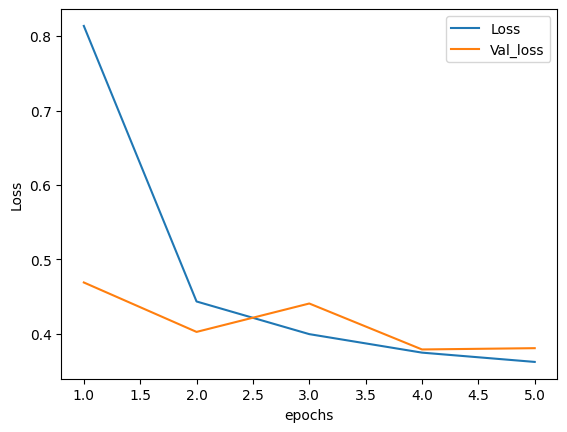

In [ ]:
q = len(hist_reduce_lr_cnn.history['loss'])

plt.figsize=(10,10)
sns.lineplot(x = range(1,1+q),y = hist_reduce_lr_cnn.history['loss'], label='Loss')
sns.lineplot(x = range(1,1+q),y = hist_reduce_lr_cnn.history['val_loss'], label='Val_loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.show()

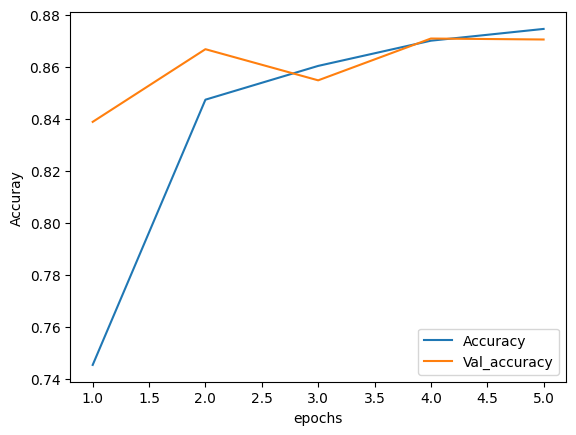

In [ ]:
q = len(hist_reduce_lr_cnn.history['accuracy'])

plt.figsize=(10,10)
sns.lineplot(x = range(1,1+q),y = hist_reduce_lr_cnn.history['accuracy'], label='Accuracy')
sns.lineplot(x = range(1,1+q),y = hist_reduce_lr_cnn.history['val_accuracy'], label='Val_accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuray')
plt.show()

#### 5.2.a.2.1 Training with Learning Rate Scheduler

In [ ]:
# Using learning rate schedulers as an adaptive learning rate

start_time=time.time()

hist_lr_sch_cnn=model_lr_sch_cnn.fit(train_images,y_train,
               epochs=5,batch_size=64,
               validation_data=(test_images,y_test),
               callbacks=lr_scheduler)

end_time=time.time()

runtime=end_time-start_time

print("Training Time: {:.2f} seconds".format(runtime))

Epoch 1/5
1607/1607 [==============================] - 1102s 685ms/step - loss: 0.8036 - accuracy: 0.7483 - val_loss: 0.4254 - val_accuracy: 0.8561 - lr: 0.0010
Epoch 2/5
1607/1607 [==============================] - 1105s 687ms/step - loss: 0.4455 - accuracy: 0.8480 - val_loss: 0.4124 - val_accuracy: 0.8609 - lr: 0.0010
Epoch 3/5
1607/1607 [==============================] - 1069s 665ms/step - loss: 0.3961 - accuracy: 0.8624 - val_loss: 0.3914 - val_accuracy: 0.8709 - lr: 0.0010
Epoch 4/5
1607/1607 [==============================] - 1105s 688ms/step - loss: 0.3784 - accuracy: 0.8689 - val_loss: 0.3786 - val_accuracy: 0.8740 - lr: 0.0010
Epoch 5/5
1607/1607 [==============================] - 1064s 662ms/step - loss: 0.3648 - accuracy: 0.8739 - val_loss: 0.5210 - val_accuracy: 0.8391 - lr: 0.0010
Training Time: 5484.84 seconds


In [ ]:
# Saving the best model
model_lr_sch_cnn.save("best_cnn_model_lr_sch.h5", overwrite=True)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### 5.2.a.2.4 Visualising with plots

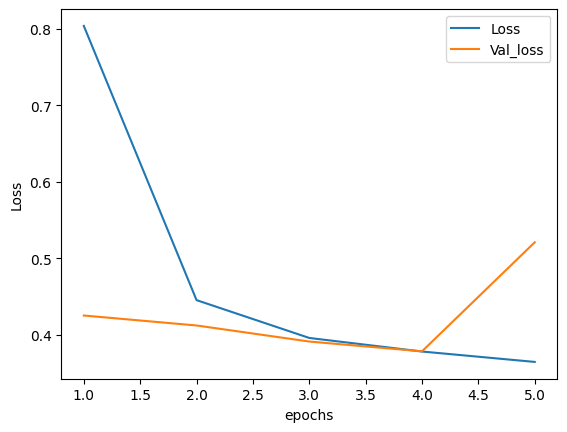

In [ ]:
q = len(hist_lr_sch_cnn.history['loss'])

plt.figsize=(10,10)
sns.lineplot(x = range(1,1+q),y = hist_lr_sch_cnn.history['loss'], label='Loss')
sns.lineplot(x = range(1,1+q),y = hist_lr_sch_cnn.history['val_loss'], label='Val_loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.show()

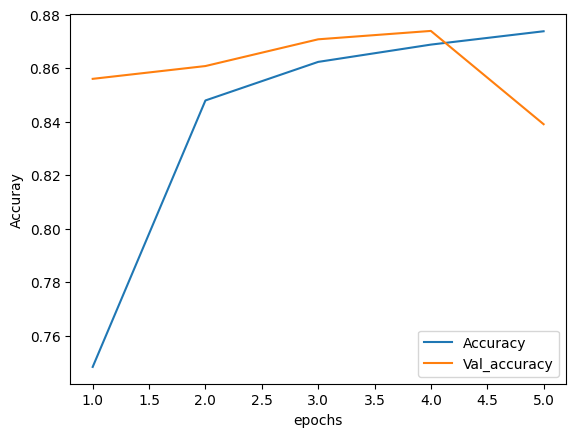

In [ ]:
q = len(hist_lr_sch_cnn.history['accuracy'])

plt.figsize=(10,10)
sns.lineplot(x = range(1,1+q),y = hist_lr_sch_cnn.history['accuracy'], label='Accuracy')
sns.lineplot(x = range(1,1+q),y = hist_lr_sch_cnn.history['val_accuracy'], label='Val_accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuray')
plt.show()

# Step-6 Performace of MLP & CNN

## 6.ai) Loading the model and print the prediction of top six samples in the testing dataset.

### 6.ai.1) Prediction with best version of MLP

In [ ]:
# Loading the MLP model with Learning rate scheduler as this particural model has performed slighty better than the model with reduce lr on plateau adaptive learning
model_lr_sch_mlp = load_model("best_mlp_w_lr_sch.h5")

In [ ]:
# evaluate test accuracy
score=model_lr_sch_mlp.evaluate(test_images,y_test,verbose=0)
test_loss=100*score[0]
test_accuracy=100*score[1]

#print test loss & accuracy
print("test loss: %.4f%%" % test_loss)
print("test accuracy: %.4f%%" % test_accuracy)

test loss: 72.2688%
test accuracy: 78.3936%


In [ ]:
# Prediction with MLP
y_hat_mlp=model_lr_sch_mlp.predict(test_images, verbose=0)

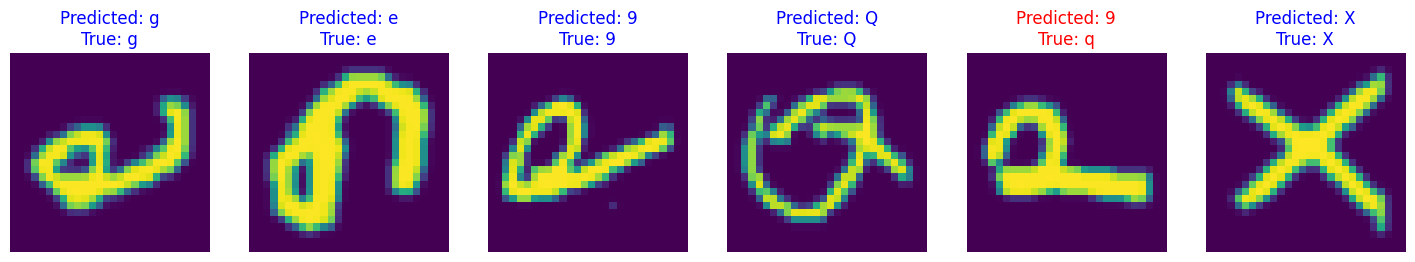

In [ ]:
# Define the EMNIST labels
emnist_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']

# Plot the top six samples
plt.figure(figsize=(18, 7))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(test_images[i])
    plt.title("Predicted: {}\nTrue: {}".format(emnist_labels[np.argmax(y_hat_mlp[i])], emnist_labels[np.argmax(test_labels[i])]),
              color=("blue" if np.argmax(y_hat_mlp[i])==np.argmax(test_labels[i]) else "red"))
    plt.axis('off')

plt.show()

### 6.ai.1) Prediction with best version of CNN

In [ ]:
# Loading the MLP model with Learning rate scheduler as this particural model has performed slighty better than the model with reduce lr on plateau adaptive learning
model_reduce_lr_cnn = load_model("best_cnn_model_reduce_lr.h5")

In [ ]:
# evaluate test accuracy
score=model_reduce_lr_cnn.evaluate(test_images,y_test,verbose=0)
test_loss=100*score[0]
test_accuracy=100*score[1]

#print test loss & accuracy
print("test loss: %.4f%%" % test_loss)
print("test accuracy: %.4f%%" % test_accuracy)

test loss: 38.0651%
test accuracy: 87.0479%


In [ ]:
# Prediction with CNN
y_hat_cnn=model_reduce_lr_cnn.predict(test_images, verbose=0)

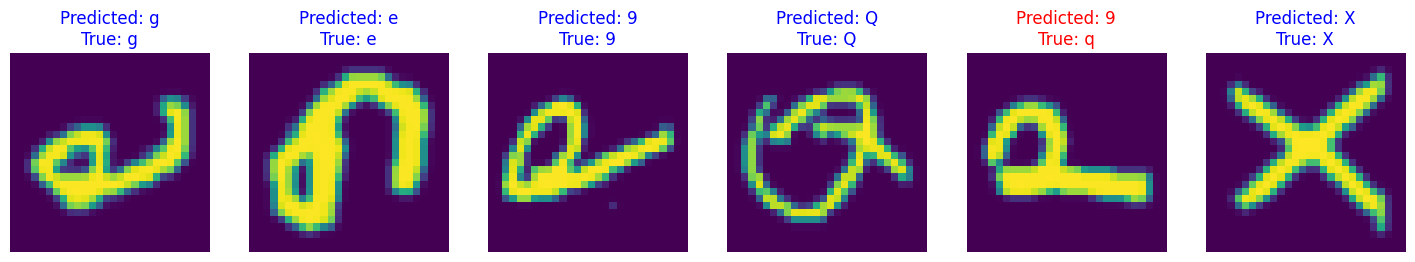

In [ ]:
# Define the EMNIST labels
emnist_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']

# Plot the top six samples
plt.figure(figsize=(18, 7))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(test_images[i])
    plt.title("Predicted: {}\nTrue: {}".format(emnist_labels[np.argmax(y_hat_cnn[i])], emnist_labels[np.argmax(test_labels[i])]),
              color=("blue" if np.argmax(y_hat_cnn[i])==np.argmax(test_labels[i]) else "red"))
    plt.axis('off')

plt.show()


## 6.aii) Plotting the confusion matrix of two model- MLP & CNN

In [ ]:
# Creating a function for plotting the confusion matrix
def plot_confution_matrix(cm, classes,normalize=False,title="confusion matrix", cmap=plt.cm.Blues):
  plt.imshow(cm,interpolation="nearest",cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks=np.arange(len(classes))
  plt.xticks(tick_marks,classes,rotation=45)
  plt.yticks(tick_marks,classes)

  thresh=cm.max()/2.
  for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i, cm[i,j],
             color="white" if cm[i,j]>thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### 6.aii.1 Confusion matrix for MLP

In [ ]:
# Rounding the prediction
y_pred_mlp=np.argmax(y_hat_mlp,axis=1)

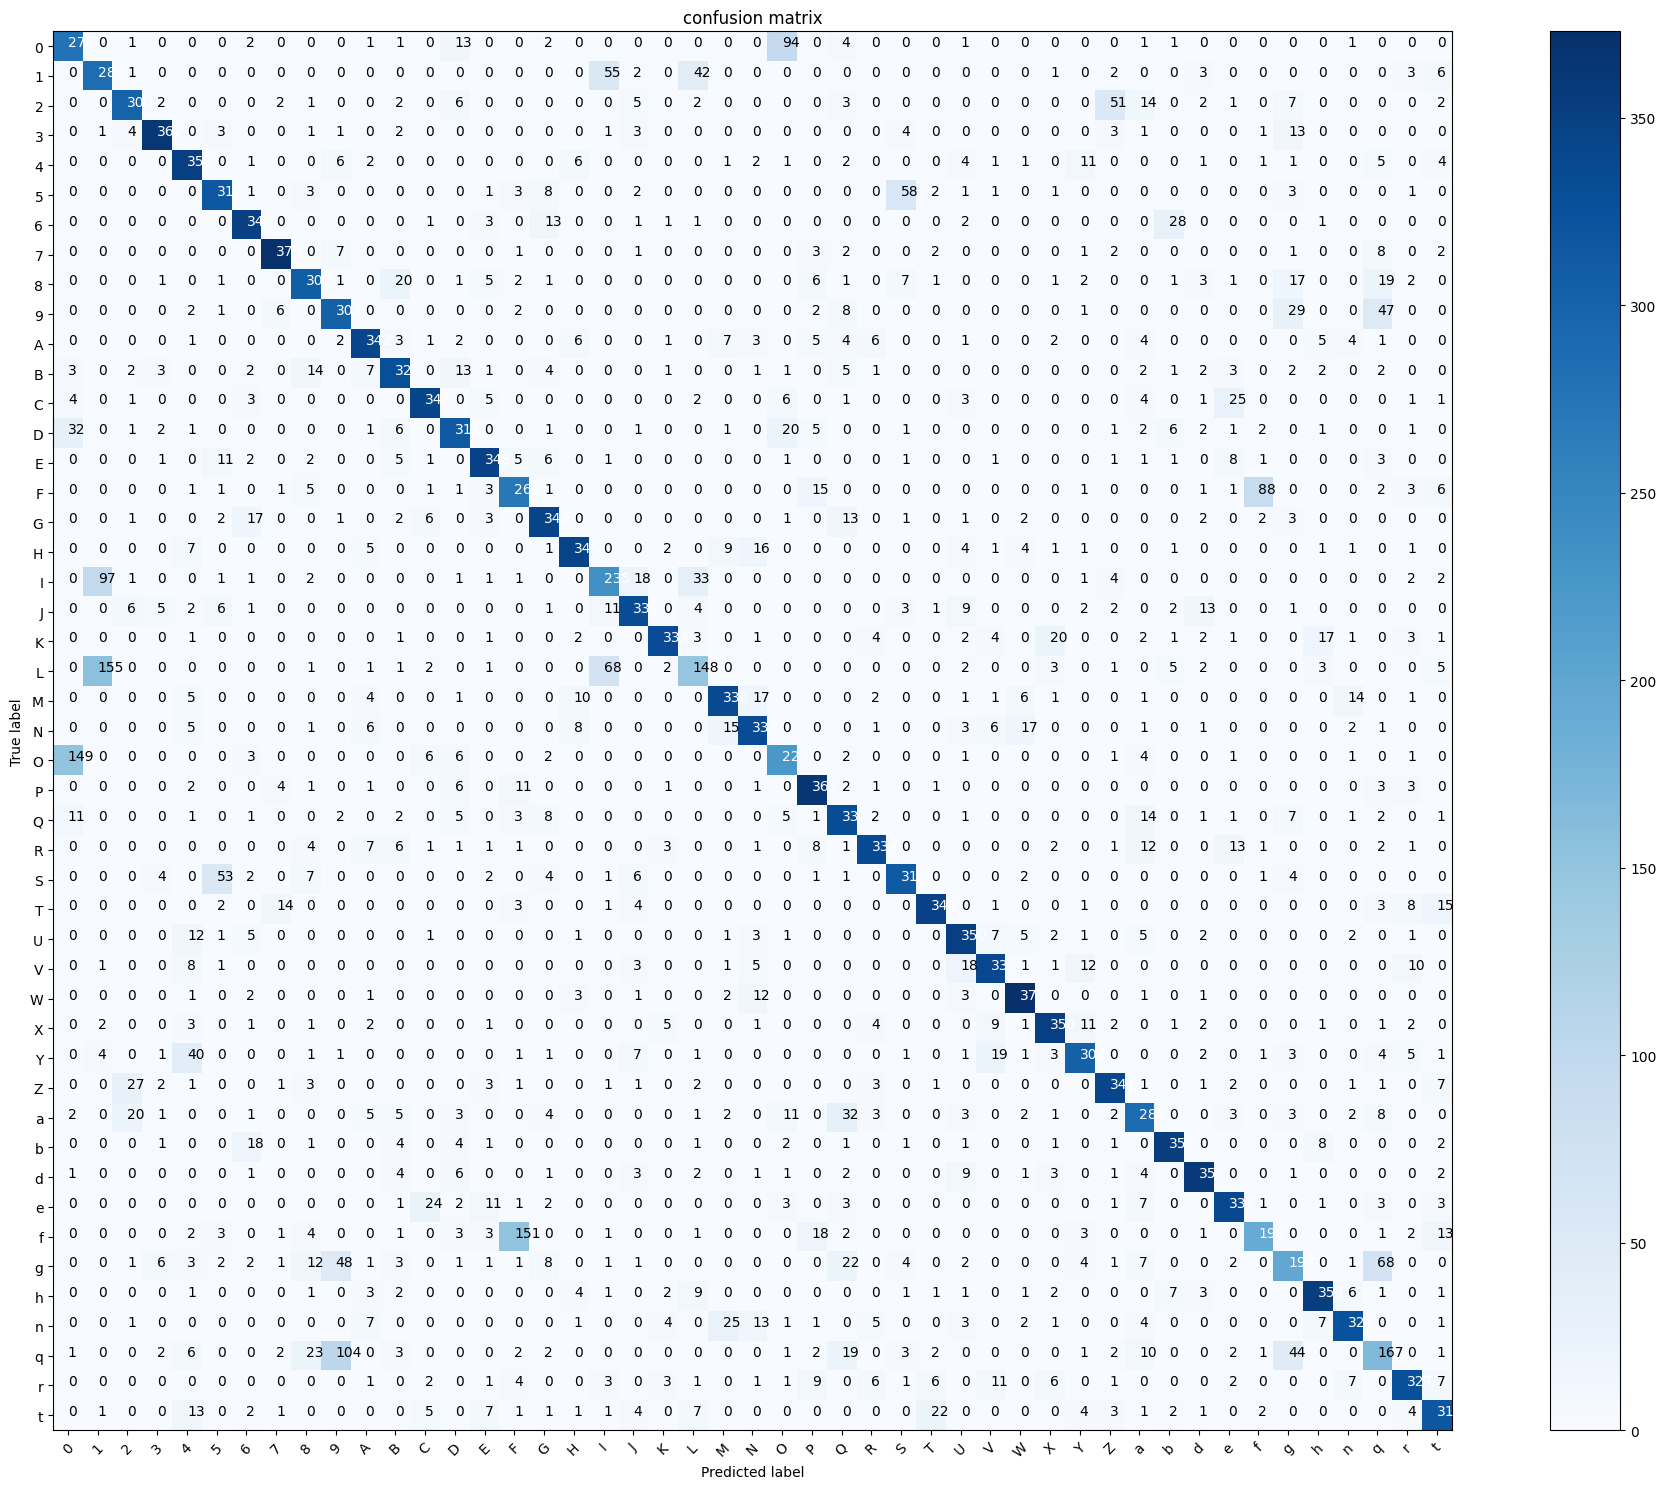

In [ ]:
cm_mlp=confusion_matrix(y_test,y_pred_mlp)

plt.figure(figsize=(20,15))
plot_confution_matrix(cm=cm_mlp,classes=emnist_labels)

### 6.a.ii.2 Confusion matrix for CNN

In [ ]:
# Rounding the prediction
y_pred_cnn=np.argmax(y_hat_cnn,axis=1)

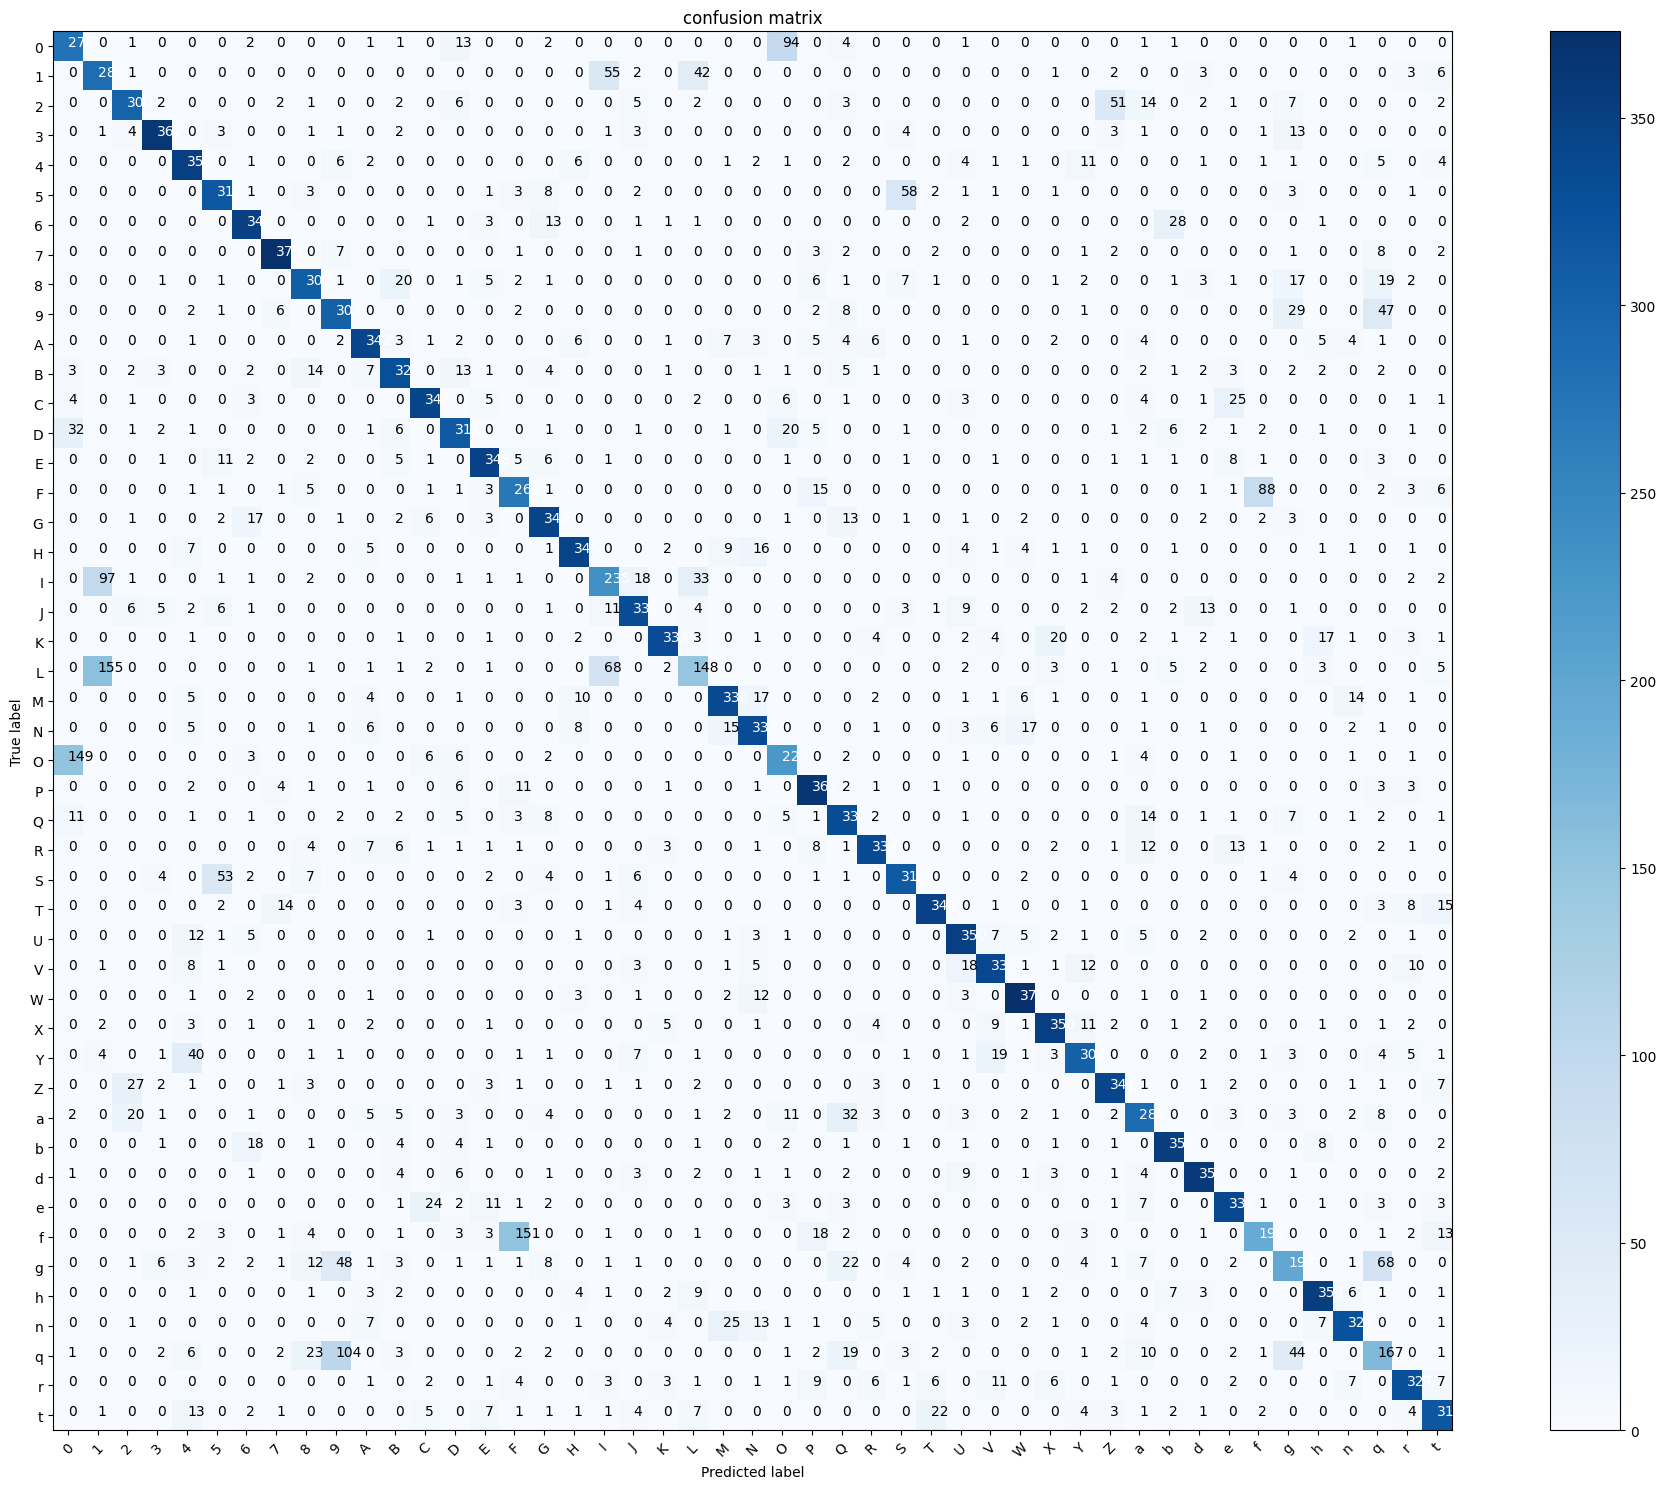

In [ ]:
cm_cnn=confusion_matrix(y_test,y_pred_mlp)

plt.figure(figsize=(20,15))
plot_confution_matrix(cm=cm_cnn,classes=emnist_labels)

## 6.a.iii) Summarizing the performance of the models- MLP & CNN

### 6.a.iii.1 Performance Metrics for MLP

In [ ]:
accuracy  = accuracy_score(y_test,y_pred_mlp).round(4)
precision = precision_score(y_test,y_pred_mlp,average="macro").round(4)
recall = recall_score(y_test,y_pred_mlp,average="macro").round(4)
f1 = f1_score(y_test,y_pred_mlp,average="macro").round(4)

print("Performace Matrices (Macro):")
print("="*25)
# Creating a Dataframe for the Evaluation Metrics
scores_mlp=[accuracy,precision,recall,f1]
test_score_mlp=pd.DataFrame(scores_mlp)
test_score_mlp["Method"]=["Accuracy","Precision","Recall","F1 Score"]
test_score_mlp["Scores"]=test_score_mlp[0]
test_score_mlp.drop(columns=0,inplace=True)
test_score_mlp

Performace Matrices (Macro):


,Method,Scores
0,Accuracy,0.7839
1,Precision,0.7849
2,Recall,0.7839
3,F1 Score,0.7824


In [ ]:
print("Classification Report for MLP:")
print("="*40)
pd.DataFrame(classification_report(y_test, y_pred_mlp, output_dict=True)).transpose()

Classification Report for MLP:


,precision,recall,f1-score,support
0,0.577963,0.695000,0.631101,400.000000
1,0.521978,0.712500,0.602537,400.000000
2,0.817439,0.750000,0.782269,400.000000
3,0.921120,0.905000,0.912989,400.000000
4,0.747863,0.875000,0.806452,400.000000
5,0.781638,0.787500,0.784558,400.000000
6,0.836930,0.872500,0.854345,400.000000
7,0.918114,0.925000,0.921544,400.000000
8,0.777215,0.767500,0.772327,400.000000
9,0.635789,0.755000,0.690286,400.000000


### 6.a.iii.2 Performance Metrics for CNN

In [ ]:
accuracy  = accuracy_score(y_test,y_pred_cnn).round(4)
precision = precision_score(y_test,y_pred_cnn,average="macro").round(4)
recall = recall_score(y_test,y_pred_cnn,average="macro").round(4)
f1 = f1_score(y_test,y_pred_cnn,average="macro").round(4)

# Creating a Dataframe for the Evaluation Metrics
scores_cnn=[accuracy,precision,recall,f1]
test_score_cnn=pd.DataFrame(scores_cnn)
test_score_cnn["Method"]=["Accuracy","Precision","Recall","F1 Score"]
test_score_cnn["Scores"]=test_score_cnn[0]
test_score_cnn.drop(columns=0,inplace=True)
test_score_cnn

,Method,Scores
0,Accuracy,0.8753
1,Precision,0.8780
2,Recall,0.8753
3,F1 Score,0.8753


In [ ]:
print("Classification Report for CNN:")
print("="*40)
pd.DataFrame(classification_report(y_test, y_pred_cnn, output_dict=True)).transpose()

Classification Report for CNN:


,precision,recall,f1-score,support
0,0.655779,0.652500,0.654135,400.000000
1,0.586035,0.587500,0.586767,400.000000
2,0.922652,0.835000,0.876640,400.000000
3,0.989899,0.980000,0.984925,400.000000
4,0.931122,0.912500,0.921717,400.000000
5,0.927614,0.865000,0.895213,400.000000
6,0.935897,0.912500,0.924051,400.000000
7,0.975062,0.977500,0.976280,400.000000
8,0.917073,0.940000,0.928395,400.000000
9,0.757485,0.632500,0.689373,400.000000
